In [20]:
import time

import numpy
import matplotlib.pyplot as plt
import numpy as np
import scipy.special as sp_spec
import scipy.stats as sp_stats
import tqdm

## Assignment 2E - LDA with SVI
In this assignment, you will implement Stochastic Variational Inference (SVI) for Latent Dirichlet Allocation (LDA) using the Coordinate Ascent Variational Inference (CAVI) updates as a template.

Your SVI implementation should be based on the CAVI implementation provided. You will need to modify the local updates to be performed on a mini-batch of documents and then update the global parameters accordingly.

For these dataset, do not expect perfect results in terms of expectations being identical to the "true" theta and beta. The focus is on correctly implementing the SVI algorithm and observing its convergence behavior compared to CAVI.
In general, SVI is faster and scales better to larger datasets compared to CAVI, but may converge to a less accurate solution in some cases.

### Generate data
The cell below generates data for the LDA model. Note, for simplicity, we are using N_d = N for all d.

In [21]:
def generate_data(D, N, K, W, eta, alpha):
    # sample K topics
    beta = sp_stats.dirichlet(eta).rvs(size=K)  # size K x W

    theta = np.zeros((D, K))   # size D x K

    w = np.zeros((D, N, W))
    z = np.zeros((D, N), dtype=int)
    for d in range(D):
        # sample document topic distribution
        theta_d = sp_stats.dirichlet(alpha).rvs(size=1)
        theta[d] = theta_d
        for n in range(N):
            # sample word to topic assignment
            z_nd = sp_stats.multinomial(n=1, p=theta[d, :]).rvs(size=1).argmax(axis=1)[0]

            # sample word
            w_nd = sp_stats.multinomial(n=1, p=beta[z_nd, :]).rvs(1)

            z[d, n] = z_nd
            w[d, n] = w_nd

    return w, z, theta, beta

D_sim = 500
N_sim = 50
K_sim = 2
W_sim = 5

eta_sim = np.ones(W_sim)
eta_sim[3] = 0.0001  # Expect word 3 to not appear in data
eta_sim[1] = 3.  # Expect word 1 to be most common in data
alpha_sim = np.ones(K_sim) * 1.0
w0, z0, theta0, beta0 = generate_data(D_sim, N_sim, K_sim, W_sim, eta_sim, alpha_sim)
w_cat = w0.argmax(axis=-1)  # remove one hot encoding
unique_z, counts_z = numpy.unique(z0[0, :], return_counts=True)
unique_w, counts_w = numpy.unique(w_cat[0, :], return_counts=True)

# Sanity checks for data generation
print(f"Average z of each document should be close to theta of document. \n Theta of doc 0: {theta0[0]} \n Mean z of doc 0: {counts_z/N_sim}")
print(f"Beta of topic 0: {beta0[0]}")
print(f"Beta of topic 1: {beta0[1]}")
print(f"Word to topic assignment, z, of document 0: {z0[0, 0:10]}")
print(f"Observed words, w, of document 0: {w_cat[0, 0:10]}")
print(f"Unique words and count of document 0: {[f'{u}: {c}' for u, c in zip(unique_w, counts_w)]}")

Average z of each document should be close to theta of document. 
 Theta of doc 0: [0.44432458 0.55567542] 
 Mean z of doc 0: [0.36 0.64]
Beta of topic 0: [0.00509409 0.63746039 0.24652082 0.         0.1109247 ]
Beta of topic 1: [0.07322534 0.42700516 0.39144198 0.         0.10832752]
Word to topic assignment, z, of document 0: [1 1 1 1 1 1 1 1 1 1]
Observed words, w, of document 0: [0 1 0 4 2 1 1 1 2 2]
Unique words and count of document 0: ['0: 2', '1: 23', '2: 18', '4: 7']


In [22]:
import os
# Force the threading layer to be compatible with Jupyter on macOS
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["OMP_NUM_THREADS"] = "1"

import torch
print(f"Torch version {torch.__version__} loaded.")

Torch version 2.9.1 loaded.


In [23]:
import torch
import torch.distributions as t_dist

def generate_data_torch(D, N, K, W, eta, alpha):
    """
    Torch implementation for generating data using the LDA model. Needed for sampling larger datasets.
    """
    # sample K topics
    beta_dist = t_dist.Dirichlet(torch.from_numpy(eta))
    beta = beta_dist.sample([K])  # size K x W

    # sample document topic distribution
    theta_dist = t_dist.Dirichlet(torch.from_numpy(alpha))
    theta = theta_dist.sample([D])

    # sample word to topic assignment
    z_dist = t_dist.OneHotCategorical(probs=theta)
    z = z_dist.sample([N])
    z = torch.einsum("ndk->dnk", z)

    # sample word from selected topics
    beta_select = torch.einsum("kw, dnk -> dnw", beta, z)
    w_dist = t_dist.OneHotCategorical(probs=beta_select)
    w = w_dist.sample([1])

    w = w.reshape(D, N, W)

    return w.numpy(), z.numpy(), theta.numpy(), beta.numpy()

### Helper functions

In [24]:
def log_multivariate_beta_function(a, axis=None):
    return np.sum(sp_spec.gammaln(a)) - sp_spec.gammaln(np.sum(a, axis=axis))

### CAVI Implementation, ELBO and initialization

In [25]:
def initialize_q(w, D, N, K, W):
    """
    Random initialization.
    """
    phi_init = np.random.random(size=(D, N, K))
    phi_init = phi_init / np.sum(phi_init, axis=-1, keepdims=True)
    gamma_init = np.random.randint(1, 10, size=(D, K))
    lmbda_init = np.random.randint(1, 10, size=(K, W))
    return phi_init, gamma_init, lmbda_init

def update_q_Z(w, gamma, lmbda):
    D, N, W = w.shape
    K, W = lmbda.shape
    E_log_theta = sp_spec.digamma(gamma) - sp_spec.digamma(np.sum(gamma, axis=1, keepdims=True))  # size D x K
    E_log_beta = sp_spec.digamma(lmbda) - sp_spec.digamma(np.sum(lmbda, axis=1, keepdims=True))   # size K x W
    log_rho = np.zeros((D, N, K))
    w_label = w.argmax(axis=-1)
    for d in range(D):
        for n in range(N):
            E_log_beta_wdn = E_log_beta[:, int(w_label[d, n])]
            E_log_theta_d = E_log_theta[d]
            log_rho_n = E_log_theta_d + E_log_beta_wdn
            log_rho[d, n, :] = log_rho_n

    phi = np.exp(log_rho - sp_spec.logsumexp(log_rho, axis=-1, keepdims=True))
    return phi

def update_q_theta(phi, alpha):
    E_Z = phi
    D, N, K = phi.shape
    gamma = np.zeros((D, K))
    for d in range(D):
        E_Z_d = E_Z[d]
        gamma[d] = alpha + np.sum(E_Z_d, axis=0)  # sum over N
    return gamma

def update_q_beta(w, phi, eta):
    E_Z = phi
    D, N, W = w.shape
    K = phi.shape[-1]
    lmbda = np.zeros((K, W))
    for k in range(K):
        lmbda[k, :] = eta
        for d in range(D):
            for n in range(N):
                lmbda[k, :] += E_Z[d,n,k] * w[d,n]  # Sum over d and n
    return lmbda

def calculate_elbo(w, phi, gamma, lmbda, eta, alpha):
    D, N, K = phi.shape
    W = eta.shape[0]
    E_log_theta = sp_spec.digamma(gamma) - sp_spec.digamma(np.sum(gamma, axis=1, keepdims=True))  # size D x K
    E_log_beta = sp_spec.digamma(lmbda) - sp_spec.digamma(np.sum(lmbda, axis=1, keepdims=True))  # size K x W
    E_Z = phi  # size D, N, K
    log_Beta_alpha = log_multivariate_beta_function(alpha)
    log_Beta_eta = log_multivariate_beta_function(eta)
    log_Beta_gamma = np.array([log_multivariate_beta_function(gamma[d, :]) for d in range(D)])
    dg_gamma = sp_spec.digamma(gamma)
    log_Beta_lmbda = np.array([log_multivariate_beta_function(lmbda[k, :]) for k in range(K)])
    dg_lmbda = sp_spec.digamma(lmbda)

    neg_CE_likelihood = np.einsum("dnk, kw, dnw", E_Z, E_log_beta, w)
    neg_CE_Z = np.einsum("dnk, dk -> ", E_Z, E_log_theta)
    neg_CE_theta = -D * log_Beta_alpha + np.einsum("k, dk ->", alpha - 1, E_log_theta)
    neg_CE_beta = -K * log_Beta_eta + np.einsum("w, kw ->", eta - 1, E_log_beta)
    H_Z = -np.einsum("dnk, dnk ->", E_Z, np.log(E_Z))
    gamma_0 = np.sum(gamma, axis=1)
    dg_gamma0 = sp_spec.digamma(gamma_0)
    H_theta = np.sum(log_Beta_gamma + (gamma_0 - K) * dg_gamma0 - np.einsum("dk, dk -> d", gamma - 1, dg_gamma))
    lmbda_0 = np.sum(lmbda, axis=1)
    dg_lmbda0 = sp_spec.digamma(lmbda_0)
    H_beta = np.sum(log_Beta_lmbda + (lmbda_0 - W) * dg_lmbda0 - np.einsum("kw, kw -> k", lmbda - 1, dg_lmbda))
    return neg_CE_likelihood + neg_CE_Z + neg_CE_theta + neg_CE_beta + H_Z + H_theta + H_beta

def CAVI_algorithm(w, K, n_iter, eta, alpha):
  D, N, W = w.shape
  phi, gamma, lmbda = initialize_q(w, D, N, K, W)

  # Store output per iteration
  elbo = np.zeros(n_iter)
  phi_out = np.zeros((n_iter, D, N, K))
  gamma_out = np.zeros((n_iter, D, K))
  lmbda_out = np.zeros((n_iter, K, W))
  
  pbar = tqdm.tqdm(range(n_iter))
  for i in pbar:

    ###### CAVI updates #######

    # q(Z) update
    phi = update_q_Z(w, gamma, lmbda)

    # q(theta) update
    gamma = update_q_theta(phi, alpha)

    # q(beta) update
    lmbda = update_q_beta(w, phi, eta)

    # ELBO
    elbo[i] = calculate_elbo(w, phi, gamma, lmbda, eta, alpha)
    
    # outputs
    phi_out[i] = phi
    gamma_out[i] = gamma
    lmbda_out[i] = lmbda
    
    pbar.set_description(f"ELBO: {elbo[i]:.2f}")

  return phi_out, gamma_out, lmbda_out, elbo

n_iter0 = 100
K0 = K_sim
W0 = W_sim
eta_prior0 = np.ones(W0)
alpha_prior0 = np.ones(K0)
phi_out0, gamma_out0, lmbda_out0, elbo0 = CAVI_algorithm(w0, K0, n_iter0, eta_prior0, alpha_prior0)
final_phi0 = phi_out0[-1]
final_gamma0 = gamma_out0[-1]
final_lmbda0 = lmbda_out0[-1]

ELBO: -27174.98: 100%|██████████| 100/100 [00:12<00:00,  7.89it/s]


In [26]:
precision = 3
print(f"----- Recall label switching - compare E[theta] and true theta and check for label switching -----")
print(f"Final E[theta] of doc 0 CAVI:  {np.round(final_gamma0[0] / np.sum(final_gamma0[0], axis=0, keepdims=True), precision)}")
print(f"True theta of doc 0:          {np.round(theta0[0], precision)}")

print(f"----- Recall label switching - e.g. E[beta_0] could be fit to true theta_1. -----")
print(f"Final E[beta] k=0: {np.round(final_lmbda0[0, :] / np.sum(final_lmbda0[0, :], axis=-1, keepdims=True), precision)}")
print(f"Final E[beta] k=1: {np.round(final_lmbda0[1, :] / np.sum(final_lmbda0[1, :], axis=-1, keepdims=True), precision)}")
print(f"True beta k=0: {np.round(beta0[0, :], precision)}")
print(f"True beta k=1: {np.round(beta0[1, :], precision)}")

----- Recall label switching - compare E[theta] and true theta and check for label switching -----
Final E[theta] of doc 0 CAVI:  [0.448 0.552]
True theta of doc 0:          [0.444 0.556]
----- Recall label switching - e.g. E[beta_0] could be fit to true theta_1. -----
Final E[beta] k=0: [0.    0.733 0.159 0.    0.109]
Final E[beta] k=1: [0.087 0.271 0.524 0.    0.119]
True beta k=0: [0.005 0.637 0.247 0.    0.111]
True beta k=1: [0.073 0.427 0.391 0.    0.108]


### SVI Implementation

Using the CAVI updates as a template, finish the code below.

In [ ]:
def update_q_Z_svi(batch, w, gamma, lmbda):
    """
    rewrite CAVI update to SVI update
    
    We reuse the CAVI update method here since the update for q(Z) does not depend on the global parameters directly.
    """

    # w[batch] shape: (S, N, W)
    # gamma[batch] shape: (S, K)
    # lmbda shape: (K, W) - global parameter
    phi_batch = update_q_Z(w[batch], gamma[batch], lmbda)

    return phi_batch

def update_q_theta_svi(batch, phi, alpha):
    """
    rewrite CAVI update to SVI update
    
    As above we reuse the Cavi method 
    """
    gamma_batch = update_q_theta(phi[batch], alpha)
    return gamma_batch

def update_q_beta_svi(batch, w, phi, eta):
    """
    rewrite CAVI update to SVI update
    """
    D = w.shape[0]
    # ONe hot encoded words 
    w_batch = w[batch]  # shape S, N, W
    # prob that word n in doc d is assigned to topic k
    phi_batch = phi[batch]  # shape S, N, K
    K = phi.shape[-1] # -1 -> last index 
    
    # Calculcates how much did topic K contributed to Word V in this batch -> Suffiecient statistics
    batch_stats = np.einsum('snk, snv -> kv', phi_batch, w_batch)
    
    # Scale the stats by D/S (total docs / batch size) and add prior
    lmbda_hat = eta + (D / len(batch)) * batch_stats
    
    return lmbda_hat

def SVI_algorithm(w, K, S, n_iter, eta, alpha):
  """
  Add SVI Specific code here.
  """
  D, N, W = w.shape
  phi, gamma, lmbda = initialize_q(w, D, N, K, W)

  # Store output per iteration
  elbo = np.zeros(n_iter)
  phi_out = np.zeros((n_iter, D, N, K))
  gamma_out = np.zeros((n_iter, D, K))
  lmbda_out = np.zeros((n_iter, K, W))

  delay = n_iter // 2 + 1
  forgetting_rate = 0.9
  pbar = tqdm.tqdm(range(n_iter))
  for t in pbar:

    ###### SVI updates - following figure 6 in Hoffman paper #######

    # Sample batch and set step size, rho.
    rho = (delay + t) ** (-forgetting_rate)

    ### Update locals on sampled batch_d until converge ###
    converge = False
    batch_d = np.random.randint(0, D, size=S)

    ###### SVI updates #######
    i = 0
    gamma[batch_d, :] = 1. #np.random.randint(1, 10, size=K)
    while not converge:
        ## Update local variational parameters until convergence ##
        
        # Save previous values for convergence check
        gamma_prev = gamma[batch_d].copy()
        phi_prev = phi[batch_d].copy()

        # Update local phi (Z)
        phi[batch_d] = update_q_Z_svi(batch_d, w, gamma, lmbda)
        
        # Update local gamma (theta)
        gamma[batch_d] = update_q_theta_svi(batch_d, phi, alpha)
        
        
        # converge condition
        i += 1
        if (np.sum(np.abs(gamma_prev - gamma[batch_d])) < S*0.1 and \
                np.sum(np.abs(phi_prev - phi[batch_d])) < S*0.1) or i > 50:
            converge = True

    ### Update globals ###
    # Calculate intermediate lambda (lambda_hat)
    lmbda_hat = update_q_beta_svi(batch_d, w, phi, eta)
    
    # Stochastic update of global lambda
    # TODO 
    lmbda = (1 - rho) * lmbda + rho * lmbda_hat

    # ELBO
    elbo[t] = calculate_elbo(w, phi, gamma, lmbda, eta, alpha)

    # outputs
    phi_out[t] = phi
    gamma_out[t] = gamma
    lmbda_out[t] = lmbda
      
    pbar.set_description(f"ELBO: {elbo[t]:.2f}")

  return phi_out, gamma_out, lmbda_out, elbo

### CASE 1

In [28]:
np.random.seed(0)

# Data simulation parameters
D1 = 50
N1 = 50
K1 = 2
W1 = 5
eta_sim1 = np.ones(W1)
alpha_sim1 = np.ones(K1)

w1, z1, theta1, beta1 = generate_data(D1, N1, K1, W1, eta_sim1, alpha_sim1)

# Inference parameters
n_iter_cavi1 = 100
n_iter_svi1 = 100
eta_prior1 = np.ones(W1) * 1.
alpha_prior1 = np.ones(K1) * 1.
S1 = N1 // 10 # batch size

start_cavi1 = time.time()
print("CAVI start")
phi_out1_cavi, gamma_out1_cavi, lmbda_out1_cavi, elbo1_cavi = CAVI_algorithm(w1, K1, n_iter_cavi1, eta_prior1, alpha_prior1)
end_cavi1 = time.time()

start_svi1 = time.time()
print("SVI start")
phi_out1_svi, gamma_out1_svi, lmbda_out1_svi, elbo1_svi = SVI_algorithm(w1, K1, S1, n_iter_svi1, eta_prior1, alpha_prior1)
end_svi1 = time.time()

final_phi1_cavi = phi_out1_cavi[-1]
final_gamma1_cavi = gamma_out1_cavi[-1]
final_lmbda1_cavi = lmbda_out1_cavi[-1]
final_phi1_svi = phi_out1_svi[-1]
final_gamma1_svi = gamma_out1_svi[-1]
final_lmbda1_svi = lmbda_out1_svi[-1]

CAVI start


ELBO: -3870.73: 100%|██████████| 100/100 [00:01<00:00, 76.56it/s]


SVI start


ELBO: -3891.68: 100%|██████████| 100/100 [00:00<00:00, 156.15it/s]


#### Evaluation
Do not expect perfect results in terms expectations being identical to the "true" theta and beta.
Do not expect the ELBO plot of your SVI alg to be the same as the CAVI alg. However, it should increase and be in the same ball park as that of the CAVI alg.

In [29]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(f"----- Recall label switching - compare E[theta] and true theta and check for label switching -----")
print(f"E[theta] of doc 0 SVI:  {final_gamma1_svi[0] / np.sum(final_gamma1_svi[0], axis=0, keepdims=True)}")
print(f"E[theta] of doc 0 CAVI: {final_gamma1_cavi[0] / np.sum(final_gamma1_cavi[0], axis=0, keepdims=True)}")
print(f"True theta of doc 0:    {theta1[0]}")

print(f"----- Recall label switching - e.g. E[beta_0] could be fit to true theta_1. -----")
print(f"E[beta] SVI k=0:    {final_lmbda1_svi[0, :] / np.sum(final_lmbda1_svi[0, :], axis=-1, keepdims=True)}")
print(f"E[beta] SVI k=1:    {final_lmbda1_svi[1, :] / np.sum(final_lmbda1_svi[1, :], axis=-1, keepdims=True)}")
print(f"E[beta] CAVI k=0:   {final_lmbda1_cavi[0, :] / np.sum(final_lmbda1_cavi[0, :], axis=-1, keepdims=True)}")
print(f"E[beta] CAVI k=1:   {final_lmbda1_cavi[1, :] / np.sum(final_lmbda1_cavi[1, :], axis=-1, keepdims=True)}")
print(f"True beta k=0:      {beta1[0, :]}")
print(f"True beta k=1:      {beta1[1, :]}")

----- Recall label switching - compare E[theta] and true theta and check for label switching -----
E[theta] of doc 0 SVI:  [0.706 0.294]
E[theta] of doc 0 CAVI: [0.475 0.525]
True theta of doc 0:    [0.676 0.324]
----- Recall label switching - e.g. E[beta_0] could be fit to true theta_1. -----
E[beta] SVI k=0:    [0.158 0.082 0.327 0.387 0.046]
E[beta] SVI k=1:    [0.186 0.322 0.103 0.180 0.210]
E[beta] CAVI k=0:   [0.276 0.347 0.129 0.095 0.154]
E[beta] CAVI k=1:   [0.075 0.011 0.351 0.503 0.059]
True beta k=0:      [0.185 0.291 0.214 0.183 0.128]
True beta k=1:      [0.136 0.075 0.291 0.434 0.063]


Time SVI: 0.6428022384643555
Time CAVI: 1.3084359169006348


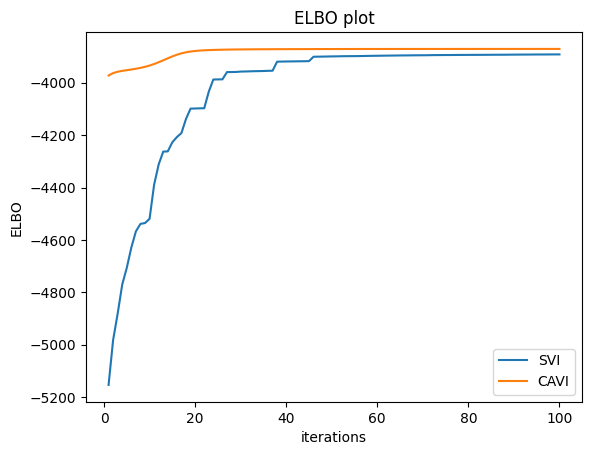

In [38]:
# Add your own code for evaluation here (will not be graded)
print(f"Time SVI: {end_svi1 - start_svi1}")
print(f"Time CAVI: {end_cavi1 - start_cavi1}")

plt.plot(list(range(1, n_iter_cavi1 + 1)), elbo1_svi[np.arange(0, n_iter_svi1, int(n_iter_svi1 / n_iter_cavi1))], label="SVI")
plt.plot(list(range(1, n_iter_cavi1 + 1)), elbo1_cavi, label="CAVI")
plt.title("ELBO plot")
plt.xlabel("iterations")
plt.ylabel("ELBO")
plt.legend()
plt.show()

In [31]:
print(f"ELBO SVI: {elbo1_svi[-1]}")
print(f"ELBO CAVI: {elbo1_cavi[-1]}")
print(f"ELBO difference: {elbo1_svi[-1] - elbo1_cavi[-1]}")
print(f"ELBO quotient: {elbo1_svi[-1]/elbo1_cavi[-1]}")

ELBO SVI: -3891.6839981048975
ELBO CAVI: -3870.734240558549
ELBO difference: -20.949757546348337
ELBO quotient: 1.0054123471786907


### CASE 2

In [32]:
np.random.seed(0)

# Data simulation parameters
D2 = 1000
N2 = 50
K2 = 3
W2 = 10
eta_sim2 = np.ones(W2)
alpha_sim2 = np.ones(K2)

w2, z2, theta2, beta2 = generate_data(D2, N2, K2, W2, eta_sim2, alpha_sim2)

# Inference parameters
n_iter_cavi2 = 100
n_iter_svi2 = 100
eta_prior2 = np.ones(W2) * 1.
alpha_prior2 = np.ones(K2) * 1.
S2 = D2 // 10 # batch size

start_cavi2 = time.time()
phi_out2_cavi, gamma_out2_cavi, lmbda_out2_cavi, elbo2_cavi = CAVI_algorithm(w2, K2, n_iter_cavi2, eta_prior2, alpha_prior2)
end_cavi2 = time.time()

start_svi2 = time.time()
phi_out2_svi, gamma_out2_svi, lmbda_out2_svi, elbo2_svi = SVI_algorithm(w2, K2, S2, n_iter_svi2, eta_prior2, alpha_prior2)
end_svi2 = time.time()

final_phi2_cavi = phi_out2_cavi[-1]
final_gamma2_cavi = gamma_out2_cavi[-1]
final_lmbda2_cavi = lmbda_out2_cavi[-1]
final_phi2_svi = phi_out2_svi[-1]
final_gamma2_svi = gamma_out2_svi[-1]
final_lmbda2_svi = lmbda_out2_svi[-1]

ELBO: -108187.48: 100%|██████████| 100/100 [00:09<00:00, 10.05it/s]


    #### Evaluation
Do not expect perfect results in terms expectations being identical to the "true" theta and beta.
Do not expect the ELBO plot of your SVI alg to be the same as the CAVI alg. However, it should increase and be in the same ball park as that of the CAVI alg.

In [33]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(f"----- Recall label switching - compare E[theta] and true theta and check for label switching -----")
print(f"E[theta] of doc 0 SVI:      {final_gamma2_svi[0] / np.sum(final_gamma2_svi[0], axis=0, keepdims=True)}")
print(f"E[theta] of doc 0 CAVI:     {final_gamma2_cavi[0] / np.sum(final_gamma2_cavi[0], axis=0, keepdims=True)}")
print(f"True theta of doc 0:        {theta2[0]}")

print(f"----- Recall label switching - e.g. E[beta_0] could be fit to true theta_1. -----")
print(f"E[beta] k=0:    {final_lmbda2_svi[0, :] / np.sum(final_lmbda2_svi[0, :], axis=-1, keepdims=True)}")
print(f"E[beta] k=1:    {final_lmbda2_svi[1, :] / np.sum(final_lmbda2_svi[1, :], axis=-1, keepdims=True)}")
print(f"E[beta] k=2:    {final_lmbda2_svi[2, :] / np.sum(final_lmbda2_svi[2, :], axis=-1, keepdims=True)}")
print(f"True beta k=0:  {beta2[0, :]}")
print(f"True beta k=1:  {beta2[1, :]}")
print(f"True beta k=2:  {beta2[2, :]}")

print(f"Time SVI: {end_svi2 - start_svi2}")
print(f"Time CAVI: {end_cavi2 - start_cavi2}")

----- Recall label switching - compare E[theta] and true theta and check for label switching -----
E[theta] of doc 0 SVI:      [0.392 0.137 0.471]
E[theta] of doc 0 CAVI:     [0.238 0.338 0.424]
True theta of doc 0:        [0.128 0.619 0.253]
----- Recall label switching - e.g. E[beta_0] could be fit to true theta_1. -----
E[beta] k=0:    [0.051 0.064 0.054 0.266 0.042 0.009 0.032 0.026 0.367 0.089]
E[beta] k=1:    [0.149 0.175 0.047 0.114 0.015 0.055 0.003 0.335 0.057 0.051]
E[beta] k=2:    [0.322 0.034 0.109 0.027 0.003 0.114 0.033 0.166 0.057 0.136]
True beta k=0:  [0.067 0.105 0.077 0.066 0.046 0.087 0.048 0.186 0.277 0.040]
True beta k=1:  [0.139 0.067 0.074 0.230 0.007 0.008 0.002 0.158 0.134 0.181]
True beta k=2:  [0.295 0.123 0.047 0.116 0.010 0.078 0.012 0.222 0.057 0.041]
Time SVI: 9.9584219455719
Time CAVI: 32.75322222709656


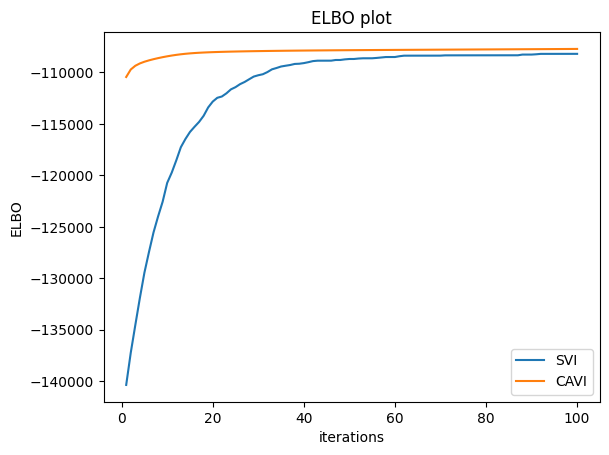

In [39]:
# Add your own code for evaluation here (will not be graded)
plt.plot(list(range(1, n_iter_cavi2 + 1)), elbo2_svi[np.arange(0, n_iter_svi2, int(n_iter_svi2 / n_iter_cavi2))], label="SVI")
plt.plot(list(range(1, n_iter_cavi2 + 1)), elbo2_cavi, label="CAVI")
plt.title("ELBO plot")
plt.xlabel("iterations")
plt.ylabel("ELBO")
plt.legend()  # Add a legend
plt.show()

In [35]:
print(f"ELBO SVI: {elbo2_svi[-1]}")
print(f"ELBO CAVI: {elbo2_cavi[-1]}")
print(f"ELBO difference: {elbo2_svi[-1] - elbo2_cavi[-1]}")
print(f"ELBO quotient: {elbo2_svi[-1]/elbo2_cavi[-1]}")

ELBO SVI: -108187.47572933626
ELBO CAVI: -107708.32353181155
ELBO difference: -479.15219752471603
ELBO quotient: 1.0044486088151134


### CASE 3

In [36]:
np.random.seed(0)

# Data simulation parameters
D3 = 10**3
N3 = 1000
K3 = 10
W3 = 100
eta_sim3 = np.ones(W3)
alpha_sim3 = np.ones(K3)

w3, z3, theta3, beta3 = generate_data_torch(D3, N3, K3, W3, eta_sim3, alpha_sim3)

# Inference parameters
n_iter3 = 1
eta_prior3 = np.ones(W3) * 1.
alpha_prior3 = np.ones(K3) * 1.
S3 = D3 // 10 # batch size

start_cavi3 = time.time()
phi_out3_cavi, gamma_out3_cavi, lmbda_out3_cavi, elbo3_cavi = CAVI_algorithm(w3, K3, n_iter3, eta_prior3, alpha_prior3)
end_cavi3 = time.time()

start_svi3 = time.time()
phi_out3_svi, gamma_out3_svi, lmbda_out3_svi, elbo3_svi = SVI_algorithm(w3, K3, S3, n_iter3, eta_prior3, alpha_prior3)
end_svi3 = time.time()

final_phi3_cavi = phi_out3_cavi[-1]
final_gamma3_cavi = gamma_out3_cavi[-1]
final_lmbda3_cavi = lmbda_out3_cavi[-1]
final_phi3_svi = phi_out3_svi[-1]
final_gamma3_svi = gamma_out3_svi[-1]
final_lmbda3_svi = lmbda_out3_svi[-1]

ELBO: -5249294.18: 100%|██████████| 1/1 [00:11<00:00, 11.78s/it]


In [37]:
# Add your own code for evaluation here (will not be graded)
print(f"Time SVI: {end_svi3 - start_svi3}")
print(f"Time CAVI: {end_cavi3 - start_cavi3}")

Time SVI: 11.887727975845337
Time CAVI: 21.53684115409851
